<a href="https://colab.research.google.com/github/rahiakela/data-science-research-and-practice/blob/main/data-science-bookcamp/case-study-5--predicting-future-friendships/03_network_driven_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Network-Driven Machine Learning

We want to construct a model that maps inputted iris measurements to one of three species categories. 

In machine learning, these inputted measurements are called **features**. Meanwhile, the outputted categories are called **classes**. 

The goal of supervised learning is to construct a model that can identify classes based on features. Such a model is called a **classifier**.

##Setup

In [ ]:
!pip install networkx

In [2]:
import re
import glob
import time
import numpy as np
import pandas as pd

from collections import Counter
from collections import defaultdict

import networkx as nx

from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

In [3]:
import warnings
warnings.filterwarnings('ignore')

##Dataset

In [4]:
# Loading iris features and class labels
X, y = load_iris(return_X_y=True)

num_classes = len(set(y))
print(f"We have {y.size} labeled examples across the following {num_classes} classes:\n{set(y)}\n")
print(f"First four feature rows:\n{X[:4]}")
print(f"\nFirst four labels:\n{y[:4]}")

We have 150 labeled examples across the following 3 classes:
{0, 1, 2}

First four feature rows:
[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]]

First four labels:
[0 0 0 0]


All 150 flower measurements have been labeled as belonging to one of three flower species. 

Imagine that we only have the resources to label one-fourth of the flowers. We'd label the data then train a model to predict the classes of the remaining flowers. 

Lets simulate this scenario.

In [5]:
# Creating a training set
sampling_size = int(y.size / 4)

x_train, y_train =X[:sampling_size], y[:sampling_size]
print(f"Training set labels:\n{y_train}")

Training set labels:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Our training set contains just the labeled examples with _Species 0_. The remaining two flower species are not represented. 

In order to increase representation, we should sample at random from `X` and `y`.

In [6]:
# Creating a training set through random sampling
np.random.seed(0)

x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.25)
print(f"Training set labels:\n{y_train}")

Training set labels:
[0 2 1 2 1 0 2 0 2 0 0 2 0 2 1 1 1 2 2 1 1 0 1 2 2 0 1 1 1 1 0 0 0 2 1 2 0]


Since the features within the iris dataset can be plotted in multi-dimensional space. This plotted data forms spatial clusters. 

Hence, elements in `X_test` are more likely to share their class with the `X_train` points found in the adjacent cluster. 

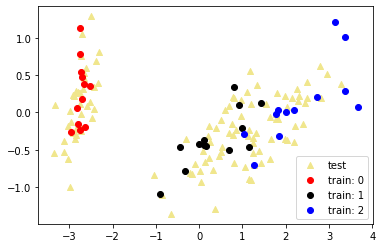

In [7]:
# Plotting the training and test sets
pca_model = PCA()
transformed_data_2D = pca_model.fit_transform(x_train)

unlabeled_data = pca_model.transform(x_test)

plt.scatter(unlabeled_data[:, 0], unlabeled_data[:, 1], color="khaki", marker="^", label="test")
for label in range(3):
  data_subset = transformed_data_2D[y_train == label]
  plt.scatter(data_subset[:, 0], data_subset[:, 1], color=["r", "k", "b"][label], label=f"train: {label}")
plt.legend()
plt.show()

Many unlabeled points cluster around _Species 0_. These unlabeled flowers clearly belong to the same species. Elsewhere in the plot, certain unlabeled flowers are proximate to both _Species 1_ and _Species 2_. 

For each such point, we'll need to quantify which labeled species are closer. This will require us to track the Euclidean distance between each feature in `X_test` and each feature in `X_train`. 

In [9]:
# Computing Euclidean distances between points
distance_matrix = euclidean_distances(x_test, x_train)

f_train, f_test = x_test[0], X[0]
distance = distance_matrix[0][0]
print(f"Our first test set feature is {f_train}")
print(f"Our first training set feature is {f_test}")
print(f"The Euclidean distance between the features is {distance:.2f}")

Our first test set feature is [5.8 2.8 5.1 2.4]
Our first training set feature is [5.1 3.5 1.4 0.2]
The Euclidean distance between the features is 4.18


We can assume that each unlabeled point shares a class that is common to its neighbors. 

This strategy forms the basis for the **K-nearest Neighbors** algorithm, which is referred to as **KNN** for short. 

In [11]:
# Labeling a point based on its nearest neighbors
np.random.seed(6)

random_index = np.random.randint(y_test.size)
labeled_distances = distance_matrix[random_index]
# Sort all data points in the training set based on their distance and Select the top K-nearest neighbors(3) of the point
labeled_neighbors = np.argsort(labeled_distances)[:3]
labels = y_train[labeled_neighbors]

# Pick the most frequently occurring class across the K neighboring points
top_label, count = Counter(labels).most_common()[0]
print(f"The 3 nearest neighbors of Point {random_index} have the following labels:\n{labels}")
print(f"\nThe most common class label is {top_label}. It occurs {count} times.")

The 3 nearest neighbors of Point 10 have the following labels:
[2 1 2]

The most common class label is 2. It occurs 2 times.


The most common class label among the neighbors of _Point 10_ is _Label 2_. 

How does this compare to the actual class of the flower?

In [12]:
# Checking the true class of a predicted label
true_label = y_test[random_index]
print(f"The true class of Point {random_index} is {true_label}.")

The true class of Point 10 is 2.


We can reformulate KNN as a graph theory problem. We can treat each point as a node, and its label as a node attribute. 

Afterwards, we can choose an unlabeled point and extend edges to its K closest labeled neighbors. Visualizing the neighbor graph subsequently allows us to identify the point.

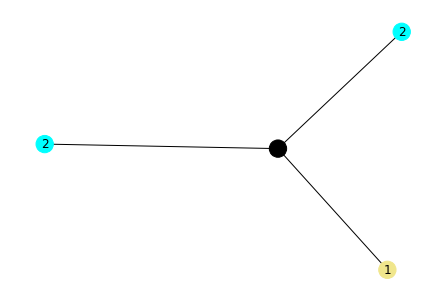

In [13]:
# Visualizing nearest neighbors with NetworkX
np.random.seed(0)

def generate_neighbor_graph(unlabeled_index, labeled_neighbors):
  G = nx.Graph()
  nodes = [(i, {"label": y_train[i]}) for i in labeled_neighbors]
  nodes.append((unlabeled_index, {"label": "U"}))
  G.add_nodes_from(nodes)
  G.add_edges_from([(i, unlabeled_index) for i in labeled_neighbors])
  labels = y_train[labeled_neighbors]
  label_colors = ["pink", "khaki", "cyan"]
  colors = [label_colors[y_train[i]] for i in labeled_neighbors] + ["k"]
  labels = {i: G.nodes[i]["label"] for i in G.nodes}
  nx.draw(G, node_color=colors, labels=labels, with_labels=True)
  plt.show()
  return G

G = generate_neighbor_graph(random_index, labeled_neighbors)

KNN works when there are just three neighbors. 

What happens if we increase the neighbor count to four?

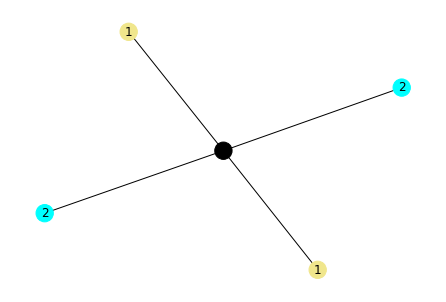

In [14]:
# Increasing the number of nearest neighbors
np.random.seed(0)

labeled_neighbors = np.argsort(labeled_distances)[:4]
G = generate_neighbor_graph(random_index, labeled_neighbors)

There is a tie! 

We can break that tie by weighing label-votes based on the inverse distance to the unlabeled point.

In [16]:
# Weighing votes of neighbors based on distance
class_to_votes = defaultdict(int)

for node in G.neighbors(random_index):
  label = G.nodes[node]["label"]
  distance = distance_matrix[random_index][node]
  num_votes = 1 / distance
  print(f"A data point with a label of {label} is {distance:.2f} units away. It receives {num_votes:.2f} votes.")
  class_to_votes[label] += num_votes

print()

for class_label, votes in class_to_votes.items():
  print(f"We counted {votes:.2f} votes for class {class_label}.")

top_class = max(class_to_votes.items(), key=lambda x: x[1])[0]
print(f"Class {top_class} has received the plurality of the votes.")

A data point with a label of 2 is 0.54 units away. It receives 1.86 votes.
A data point with a label of 1 is 0.74 units away. It receives 1.35 votes.
A data point with a label of 2 is 0.77 units away. It receives 1.29 votes.
A data point with a label of 1 is 0.98 units away. It receives 1.02 votes.

We counted 3.15 votes for class 2.
We counted 2.36 votes for class 1.
Class 2 has received the plurality of the votes.


Of course, this improvement
is by no means guaranteed; occasionally, weighted voting can worsen the outputted
results. 

Depending on the preset value of our K, weighted voting can either
improve or worsen our predictions. 

We won’t know for sure until we test prediction
performance across a range of parameters.

##Measuring Predicted Label Accuracy